In [1]:
include("readin_functions.jl");

In [2]:
include("dfm_functions.jl");

In [3]:
using Plots
pyplot() # any backend is fine though
using StatPlots

┌ Warning: The start/next/done iteration protocol is deprecated. Implement `iterate(::PyCall.PyDict{PyCall.PyAny,PyCall.PyAny,true})`.
│   caller = ip:0x0
└ @ Core :-1
┌ Info: Precompiling StatPlots [60ddc479-9b66-56df-82fc-76a74619b69c]
└ @ Base loading.jl:1187


In [4]:
md = MonthlyData((1959, 1), (2014, 12), 148)
qd = QuarterlyData((1959, 1), (2014, 4), 85)

QuarterlyData(224, 85)

In [5]:
dataset = readin_data(md, qd, BiWeight(100), RealData())

(bpdata_raw = Union{Missing, Float64}[2976.63 1809.4 … 69.9 253.207; 3049.01 1837.3 … 67.0 260.367; … ; 16205.6 10999.5 … 61.7667 1654.21; 16293.7 11113.6 … 60.9667 missing], bpcatcode = Any[1.01, 1.02, 1.021, 1.022, 1.023, 1.05, 1.051, 1.052, 1.053, 1.054  …  5.1, 5.11, 5.2, 5.21, 5.22, 5.23, 5.3, 5.31, 5.32, 5.4], bpdata = Union{Missing, Float64}[missing missing … 12.3235 missing; 0.0142268 0.00530395 … 9.45272 0.0152701; … ; 0.00687755 0.00197529 … 6.72325 0.00391343; 0.000212054 0.00439543 … 5.91928 missing], bpdata_unfiltered = Union{Missing, Float64}[missing missing … 69.9 missing; 0.0240258 0.0153018 … 67.0 0.0278849; … ; 0.0121175 0.00793173 … 61.7667 0.00887936; 0.00542382 0.0103198 … 60.9667 missing], bpdata_noa = Union{Missing, Float64}[missing missing … 69.9 missing; 0.0240258 0.0153018 … 67.0 0.0278849; … ; 0.0121175 0.00793173 … 61.7667 0.00887936; 0.00542382 0.0103198 … 60.9667 missing], bpdata_trend = Union{Missing, Float64}[missing missing … 57.5765 missing; 0.00979898

In [6]:
year = dataset.calvec
data = dataset.bpdata
inclcode = dataset.inclcode

86-element Array{Int64,1}:
 2
 2
 1
 1
 1
 2
 2
 1
 1
 1
 1
 2
 1
 ⋮
 1
 2
 2
 1
 1
 1
 1
 1
 1
 1
 1
 1

In [7]:
initperiod = find_row_number((1959, 3), dataset.calds) # first two observations are dropped
lastperiod = find_row_number((2014, 4), dataset.calds)

224

In [8]:
nt_min_factor_estimation = 20 # min number of obs for any series used to est factors
nt_min_factorloading_estimation = 40 # min number of obs for any series used to estimate lamba, irfs, etc.
nfac_o = 0 # number of observed factors
nfac_u = 1 # number of unobserved factors
n_uarlag = 4 # number of AR lags for uniqueness
n_factorlag = 4 # number of lags for factor evolution VAR
tol = 1e-8

1.0e-8

In [9]:
dfmm = DFMModel(data, inclcode,
                nt_min_factor_estimation, nt_min_factorloading_estimation,
                initperiod, lastperiod, nfac_o, nfac_u, tol, n_uarlag, n_factorlag)


DFMModel(Union{Missing, Float64}[missing missing … 12.3235 missing; 0.0142268 0.00530395 … 9.45272 0.0152701; … ; 0.00687755 0.00197529 … 6.72325 0.00391343; 0.000212054 0.00439543 … 5.91928 missing], [2, 2, 1, 1, 1, 2, 2, 1, 1, 1  …  2, 1, 1, 1, 1, 1, 1, 1, 1, 1], 224, 20, 40, 3, 224, 0, 1, 1, 1.0e-8, FactorEstimateStats(222, 58, missing, missing, missing, Union{Missing, Float64}[missing, missing, missing, missing, missing, missing, missing, missing, missing, missing  …  missing, missing, missing, missing, missing, missing, missing, missing, missing, missing]), Union{Missing, Float64}[missing; missing; … ; missing; missing], [0.0; 0.0; … ; 6.94922e-310; 6.94923e-310], [2.47033e-323 2.0899e-321 3.02862e-321 2.47033e-323; 1.23022e-321 2.47033e-323 1.17094e-321 1.63042e-321; … ; 2.47033e-323 1.99108e-321 1.60571e-321 2.47033e-323; 1.32904e-321 2.47033e-323 1.07212e-321 1.56125e-321], [6.94922e-310, 6.94922e-310, 6.94922e-310, 6.94922e-310, 6.94922e-310, 6.94922e-310, 6.94922e-310, 6.9492

In [10]:
estimate!(dfmm, NonParametric())

In [11]:
function plot_skipmissing!(p, x, y; args...)
    x_copy, y_copy = copy(x), copy(y)
    x_copy[ismissing.(x_copy)] .= NaN
    y_copy[ismissing.(y_copy)] .= NaN
    plot!(p, x_copy, y_copy; args...)
    return nothing
end
function plot_skipmissing(x, y; args...)
    p = plot()
    plot_skipmissing!(p, x, y; args...)
    return p
end

plot_skipmissing (generic function with 1 method)

In [12]:
function compare_series!(p, dfmm::DFMModel, namevec,
                          name, lab)
    i = findall(dataset.bpnamevec.==name)[1]
    yf = compute_series(dfmm, i)
    y4f = detrended_year_growth(yf)
    y4 = detrended_year_growth(dfmm.data[:, i])
    plot_skipmissing!(p, year, [100*y4 100*y4f], lw=2,
        lab=[lab "Common Component"], leg=:bottomleft)
    return p
end

compare_series! (generic function with 1 method)

┌ Warning: `findfirst(A, v)` is deprecated, use `something(findfirst(isequal(v), A), 0)` instead.
│   caller = #plot!#141(::Base.Iterators.Pairs{Symbol,Any,Tuple{Symbol,Symbol,Symbol},NamedTuple{(:lw, :lab, :leg),Tuple{Int64,Array{String,2},Symbol}}}, ::Function, ::Plots.Subplot{Plots.PyPlotBackend}, ::Array{Float64,1}, ::Vararg{Any,N} where N) at plot.jl:290
└ @ Plots /home/holly/.julia/packages/Plots/Gz7mu/src/plot.jl:290


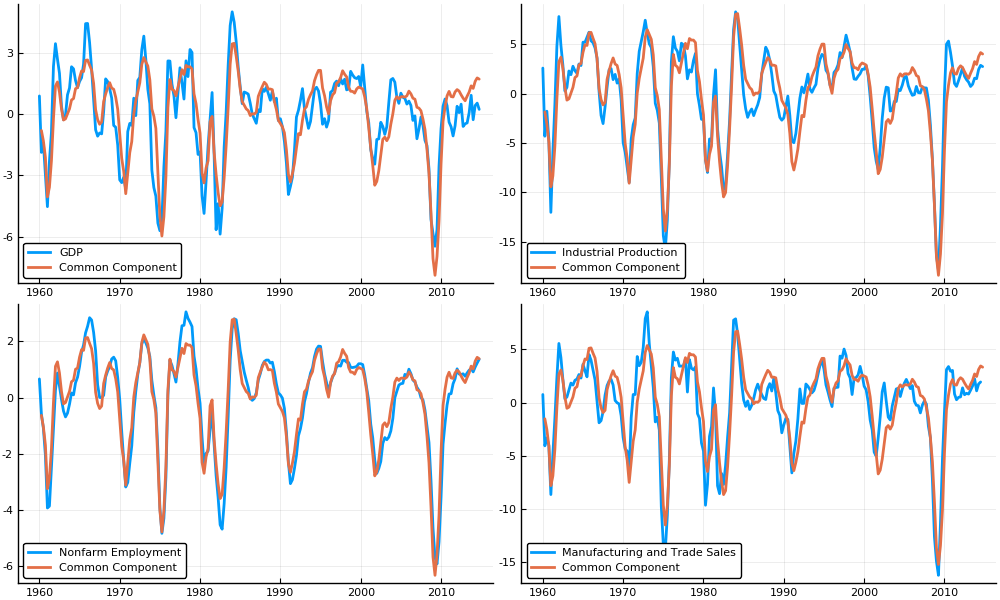

In [13]:
namevec = ["GDPC96","INDPRO","PAYEMS","A0M057"]
labvec = ["GDP", "Industrial Production",
            "Nonfarm Employment","Manufacturing and Trade Sales"]
p = plot(layout=(2,2), size=(1000,600))

for i in 1:4
    name, lab = namevec[i], labvec[i]
    compare_series!(p[i], dfmm, dataset.bpnamevec, name, lab)
end

p

# Figure 2

┌ Warning: `findfirst(A, v)` is deprecated, use `something(findfirst(isequal(v), A), 0)` instead.
│   caller = #plot!#141(::Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}}, ::Function, ::Plots.Subplot{Plots.PyPlotBackend}, ::Array{Int64,1}, ::Vararg{Any,N} where N) at plot.jl:290
└ @ Plots /home/holly/.julia/packages/Plots/Gz7mu/src/plot.jl:290
┌ Warning: `findfirst(A, v)` is deprecated, use `something(findfirst(isequal(v), A), 0)` instead.
│   caller = #plot!#141(::Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}}, ::Function, ::Plots.Subplot{Plots.PyPlotBackend}, ::StepRangeLen{Float64,Base.TwicePrecision{Float64},Base.TwicePrecision{Float64}}, ::Vararg{Any,N} where N) at plot.jl:290
└ @ Plots /home/holly/.julia/packages/Plots/Gz7mu/src/plot.jl:290


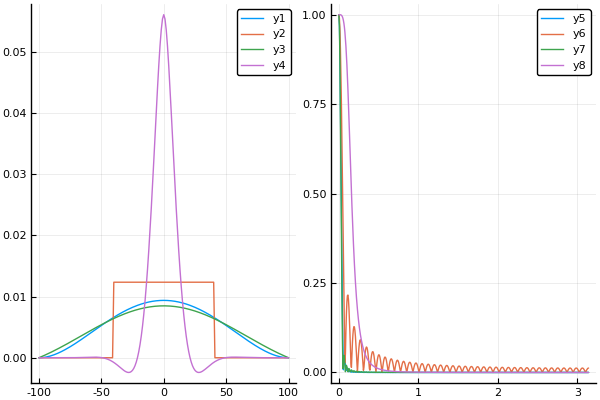

In [14]:
# Frequencies
wvec = range(0, stop=pi, length=500)
bw_para = 100
bw_weight, trend = compute_bw_weight(bw_para)
# Compute Gain
bw_gain = [Real(gain(bw_weight, wvec[i])) for i in 1:length(wvec)]

# Flat over + and - 40 quarters
ma40_weight = (abs.(trend) .<= 40)
ma40_weight = ma40_weight./sum(ma40_weight)
# Compute Gain
ma40_gain = [Real(gain(ma40_weight, wvec[i])) for i = 1:size(wvec,1)]

# Band pass, 100 terms on each side, 200 quarter cutoff;
nper = 200
ombar = 2pi/nper
t1 = 1:100
tmp0 = ombar/pi
tmp1 = (1 ./ (pi*t1)).*sin.(t1*ombar)
bp_weight = vcat(tmp1[end:-1:1], tmp0, tmp1)
bp_weight = bp_weight/sum(bp_weight)
# Compute Gain
bp_gain = [Real(gain(bp_weight, wvec[i])) for i =1:length(wvec)]
# HP
hp_weight = vec(readdlm("data/hpfilter_trend.asc"))

# Compute Gain
hp_gain = [Real(gain(hp_weight, wvec[i])) for i = 1:length(wvec)]

p = plot(layout=(1,2))
plot!(p[1], trend, [bw_weight ma40_weight bp_weight hp_weight])
plot!(p[2], wvec, [bw_gain ma40_gain bp_gain hp_gain])

# Figure 3

In [15]:
periods_all = ((1959, 3), (2014, 4))
periods_pre = ((1959, 3), (1983, 4))
periods_post = ((1984, 1), (2014, 4))

((1984, 1), (2014, 4))

In [16]:
periodss = (periods_all, periods_pre, periods_post)
trace_r2 = Matrix{Float64}(undef, 10, 3)
marg_r2 = Matrix{Float64}(undef, 10, 3)
for i = 1:3
    periods = periodss[i]
    initperiod = find_row_number(periods[1], dataset.calds)
    lastperiod = find_row_number(periods[2], dataset.calds)
    dfmm = DFMModel(data, inclcode,
          nt_min_factor_estimation, nt_min_factorloading_estimation,
          initperiod, lastperiod, nfac_o, nfac_u, tol, n_uarlag, n_factorlag)

    fnes = estimate_factor_numbers(dfmm, 1:10)

    trace_r2[:, i] = 1 .- fnes.ssr./fnes.tss

    marg_r2[1, i] = trace_r2[1, i]
    marg_r2[2:end, i] = trace_r2[2:end, i] - trace_r2[1:end-1, i]
end

┌ Warning: Deprecated syntax `implicit assignment to global variable `initperiod``.
│ Use `global initperiod` instead.
└ @ nothing none:0
┌ Warning: Deprecated syntax `implicit assignment to global variable `lastperiod``.
│ Use `global lastperiod` instead.
└ @ nothing none:0
┌ Warning: Deprecated syntax `implicit assignment to global variable `dfmm``.
│ Use `global dfmm` instead.
└ @ nothing none:0


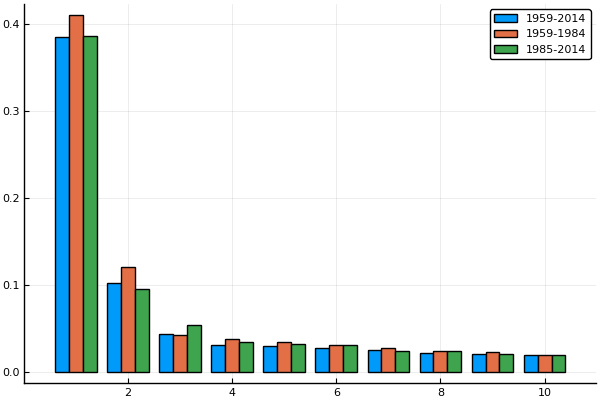

In [17]:
using StatPlots
groupedbar(1:10, marg_r2, lab=["1959-2014" "1959-1984" "1985-2014"],
           bar_position = :dodge, grid=true)

# Figure 4

In [19]:
nfs = [1, 3, 5]
dfmms = [DFMModel(data, inclcode,
            nt_min_factor_estimation, nt_min_factorloading_estimation,
            initperiod, lastperiod, nfac_o, nf, tol, n_uarlag, n_factorlag)
         for nf in nfs]
estimate!.(dfmms)

3-element Array{Nothing,1}:
 nothing
 nothing
 nothing

In [20]:
i = findall(dataset.bpnamevec.=="GDPC96")[1]
yfs = compute_series.(dfmms, i)
y4fs = detrended_year_growth.(yfs)
y4 = detrended_year_growth(dfmm.data[:, i]);

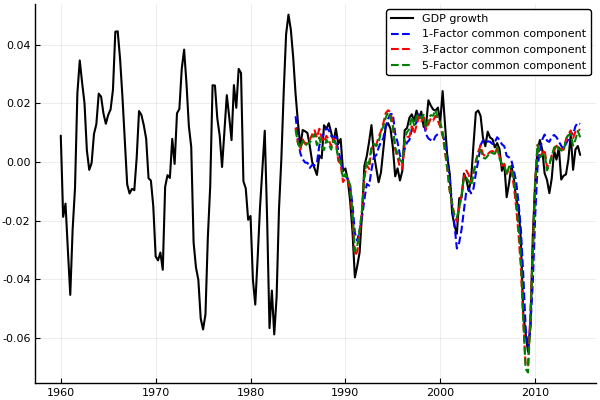

In [21]:
plot_skipmissing(year, hcat(y4, y4fs...), lw=1.5,
                lab=hcat("GDP growth", "1-Factor common component",
                        "3-Factor common component",
                        "5-Factor common component"),
                lc=[:black :blue :red :green],
                ls=[:solid :dash :dash :dash])

In [22]:
r2s = []
for i=1:length(nfs)
    tmp = ols_skipmissing(y4, [ones(length(y4)) y4fs[i]], Balanced())
    r2s = vcat(r2s, compute_r2(y4[tmp[3]], tmp[2])[1])
end

┌ Warning: Deprecated syntax `implicit assignment to global variable `i``.
│ Use `global i` instead.
└ @ nothing none:0
┌ Warning: Loop variable `i` overwrites a variable in an enclosing scope. In the future the variable will be local to the loop instead.
└ @ nothing none:0
